In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## Importing Libraries

import numpy as np
import pandas as pd 
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import os


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization


In [ ]:
print(os.listdir("/content/drive/MyDrive/nmg_object_detection"))

['sampleSubmission.csv', 'dogs-vs-cats.zip', 'test1', 'train', 'nmb_object_detection.ipynb', 'image_classifier(dogCat).ipynb', 'model(10).h5']


In [ ]:
filenames = os.listdir("/content/drive/MyDrive/nmg_object_detection/train")
categories = []
for file in filenames:
#     print(file)
    category = file.split('.')[0]
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [ ]:
## Check data is balanced or imbalanced 
df['category'].value_counts()

dog    12500
cat    12500
Name: category, dtype: int64

<font size=4>Because images for both categories is equal, data is balanced. We can start building model .</font>

### Build Model

In [3]:
img_width, img_height = 128, 128
img_channels = 3
img_size = (img_width, img_height)

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, img_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because two classes Dog & Cat

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Priting Model Summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

## Callbacks
For early stopping of training, to prevent model overfitting (if model loss is not decressing) or reducing the learning rate (when accuracy is not increasing)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlyStop = EarlyStopping(patience=10) #Stop the learning after 10 epochs if loss value not decresed

# Reduce learing rate if accuracy not increased after 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001) 
callbacks = [earlyStop, learning_rate_reduction]

## Data Preparation 

In [ ]:
## Spliting data in training and validation set

from sklearn.model_selection import train_test_split

train_set, validation_set = train_test_split(df, test_size = 0.25, random_state=42)
train_set = train_set.reset_index(drop=True)
validation_set = validation_set.reset_index(drop=True)

In [ ]:
print('Training set: ',end='\n')
print(train_set['category'].value_counts())

print('\n')
print('Validation set: ')
print(validation_set['category'].value_counts())


Training set: 
cat    9425
dog    9325
Name: category, dtype: int64


Validation set: 
dog    3175
cat    3075
Name: category, dtype: int64


In [ ]:
# Batch
total_train = train_set.shape[0]
total_validate = validation_set.shape[0]
batch_size=20



# Image Data Generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img

# Training generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_set, 
    "/content/drive/MyDrive/nmg_object_detection/train/", 
    x_col='filename',
    y_col='category',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size
)

# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_set, 
    "/content/drive/MyDrive/nmg_object_detection/train", 
    x_col='filename',
    y_col='category',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size
)


Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.


In [ ]:
## Check how generator works 

example_df = train_set.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/drive/MyDrive/nmg_object_detection/train", 
    x_col='filename',
    y_col='category',
    target_size=img_size,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


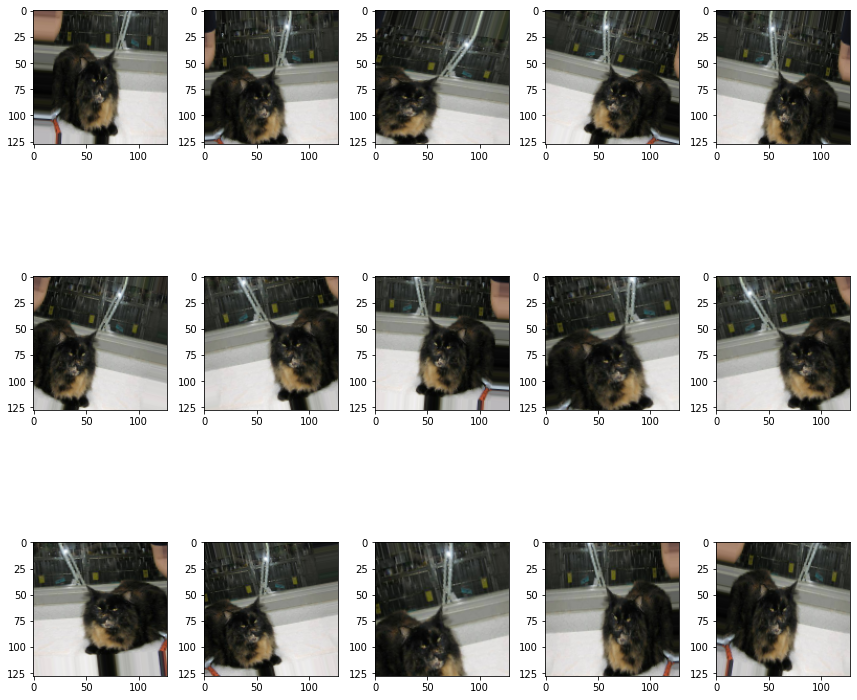

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(3, 5, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model 

In [ ]:
epochs = 30

history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
937/937 [==============================] - 200s 211ms/step - loss: 0.7683 - accuracy: 0.6145 - val_loss: 0.6033 - val_accuracy: 0.6867
Epoch 2/30
937/937 [==============================] - 199s 212ms/step - loss: 0.6047 - accuracy: 0.6824 - val_loss: 0.5990 - val_accuracy: 0.6902
Epoch 3/30
937/937 [==============================] - 198s 211ms/step - loss: 0.5637 - accuracy: 0.7163 - val_loss: 1.0080 - val_accuracy: 0.5776
Epoch 4/30
937/937 [==============================] - 201s 215ms/step - loss: 0.5308 - accuracy: 0.7364 - val_loss: 0.4514 - val_accuracy: 0.7869
Epoch 5/30
937/937 [==============================] - 200s 214ms/step - loss: 0.5052 - accuracy: 0.7569 - val_loss: 0.4705 - val_accuracy: 0.7970
Epoch 6/30
937/937 [==============================] - 199s 212ms/step - loss: 0.4924 - accuracy: 0.7646 - val_loss: 0.4602 - val_accuracy: 0.7897
Epoch 7/30
937/937 [==============================] - 201s 215ms/step - loss: 0.4813 - accuracy: 0.7730 - val_loss: 0.4620 -

# Save Model

In [ ]:
model.save_weights("/content/drive/MyDrive/nmg_object_detection/model(30).h5") 

# Plotting Training Curve 

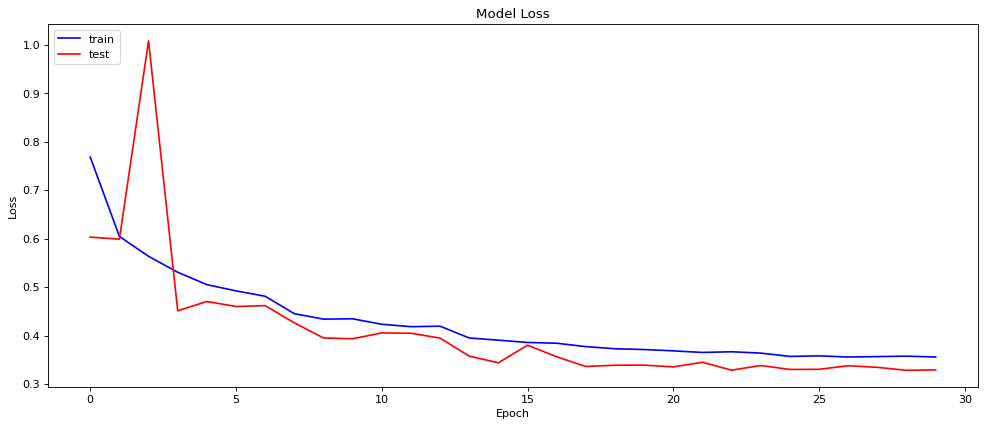

In [ ]:
# Training Loss Curve
plt.figure(figsize=(15,6), dpi=80)
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','test'],loc='upper left')
plt.show() 

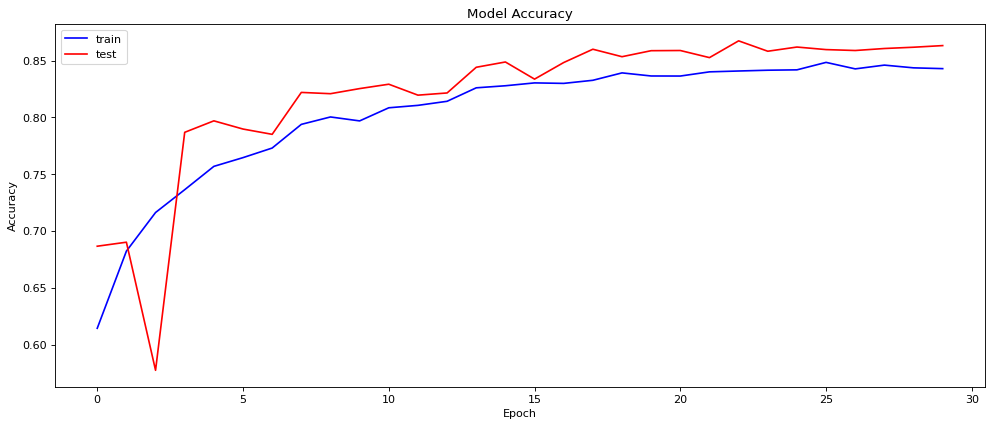

In [ ]:
# Training Accuracy Curve 
plt.figure(figsize=(15,6), dpi=80)
plt.plot(history.history['accuracy'], color='b', label="Training loss")
plt.plot(history.history['val_accuracy'], color='r', label="validation loss")
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc='upper left')
plt.show()

# Testing Dataset

In [ ]:
test_filenames = os.listdir("/content/drive/MyDrive/nmg_object_detection/test1")
test_set = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_set.shape[0]

# Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_set, 
    "/content/drive/MyDrive/nmg_object_detection/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# Predict the Image Class


In [ ]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

 <font size=3> Because Model predicting in probablity of each category, So we consider only category with highest probality</font>

In [ ]:
test_set['category'] = np.argmax(predict, axis=-1)

<font size=3> Convert predicted category back into our generator classes by using train_generator.class_indices. (map the predicted labels with their unique ids such as filenames) It is the classes that image generator map while converting data into computer vision </font>

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_set['category'] = test_set['category'].replace(label_map)

### Map results, Dog as '1' and Cat as '0'

In [ ]:
test_set['category'] = test_set['category'].replace({ 'cat': 0, 'dog': 1 })

test_set['category'].value_counts()

1    6540
0    5960
Name: category, dtype: int64

## Showing predicted result with images 

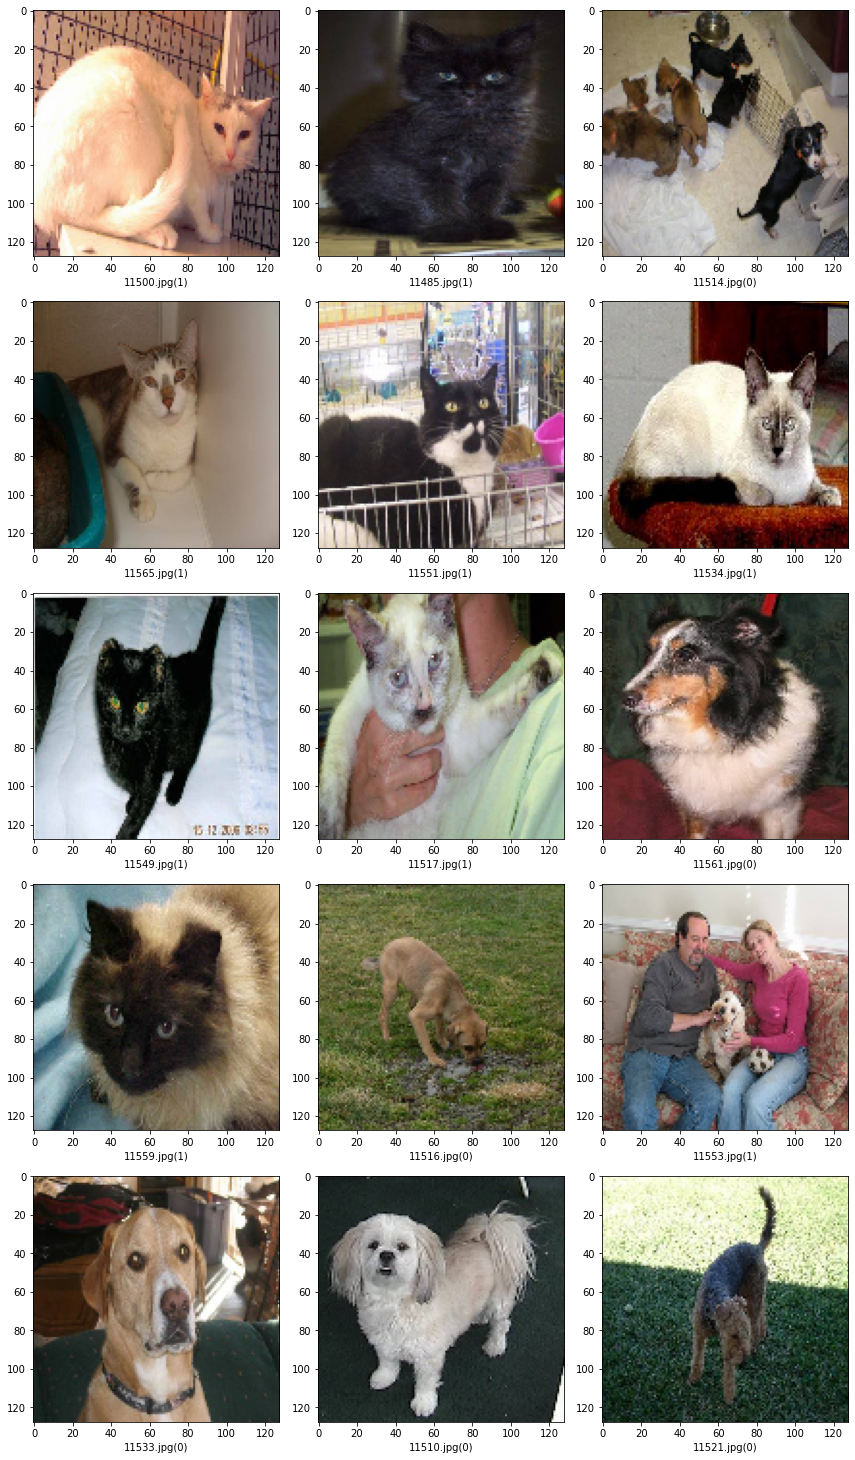

In [ ]:
sample_test = test_set.head(15)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/nmg_object_detection/test1/"+filename, target_size=img_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

## Write predicted result to file 

In [ ]:
result_df = test_set.copy()
result_df['Id'] = result_df['filename'].str.split('.').str[0]
result_df['predicted_label'] = result_df['category']
result_df.drop(['filename', 'category'], axis=1, inplace=True)
result_df.to_csv('/content/drive/MyDrive/nmg_object_detection/submission.csv', index=False)